In [ ]:
# !pip install scikit-learn
!pip install keras_tuner
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense
from tensorflow import keras
import keras_tuner as kt
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 133 kB 5.1 MB/s 


匯入貼文資料即是否逆風

In [ ]:
df = pd.read_csv('DcaTrainData.csv')
df = df.drop(['isCondemn'],axis=1)
df = df.sample(frac=1)
# x = pd.get_dummies(df.drop(['cmt'],axis=1))
# x = df.drop(['cmt'],axis=1)
x = df[['like','pGender','collection','wordCount','stLike','stCmt']]
print(x.head())
y = df['like']
testSize = 50
xtrain = x[:-testSize]
xtest = x[-testSize:]
ytrain = y[:-testSize]
ytest = y[-testSize:]

     like  pGender  collection  wordCount  stLike  stCmt
419    80        0          15       1264     955    106
135   247        0         170         79    2294     89
272   111        0          32        842    1004      0
0    2465        0        1089        816   29963    410
293   112        0          27        697    4363    102


建立模型

In [ ]:
print(xtrain.shape[1])
def model_builder(hp):
  model = keras.Sequential()
  model.add(Dense(units=hp.Int('units', min_value=16, max_value=1000, step=32),
                  activation='relu',
                  input_dim=xtrain.shape[1]))
  model.add(keras.layers.Dense(units=hp.Int('units', min_value=32, max_value=1000, step=32),
                               activation='relu'))
  model.add(keras.layers.Dense(units=hp.Int('units', min_value=32, max_value=1000, step=32),
                               activation='relu'))
  model.add(Dense(units=1))
  model.compile(optimizer='adam',
                loss=["mean_squared_error"],
                metrics=[keras.metrics.MeanAbsoluteError()])

  return model

6


In [ ]:
tuner = kt.Hyperband(model_builder,
                     objective= kt.Objective("val_mean_absolute_error", "min"),
                     max_epochs=300,
                     factor=3,
                     directory='my_dir',
                     project_name = '5'
                     )

stop_early = keras.callbacks.EarlyStopping(monitor='val_mean_squared_error', patience=50)
tuner.search(xtrain, ytrain, epochs=500, validation_split=0.1, callbacks=[stop_early])
# tuner.results_summary()

model = tuner.get_best_models()[0]

Trial 31 Complete [00h 00m 02s]
val_mean_absolute_error: 184.9744873046875

Best val_mean_absolute_error So Far: 144.87620544433594
Total elapsed time: 00h 00m 43s
INFO:tensorflow:Oracle triggered exit
Results summary
Results in my_dir/5
Showing 10 best trials
Trial summary
Hyperparameters:
units: 176
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 5
tuner/round: 0
Score: 144.87620544433594
Trial summary
Hyperparameters:
units: 336
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 5
tuner/round: 0
Score: 157.09445190429688
Trial summary
Hyperparameters:
units: 144
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 5
tuner/round: 0
Score: 158.06024169921875
Trial summary
Hyperparameters:
units: 720
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 5
tuner/round: 0
Score: 174.293701171875
Trial summary
Hyperparameters:
units: 432
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 5
tuner/round: 0
Score: 175.7325439453125
Trial summary
Hyperparameters:
units: 400
tuner

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 176)               1232      
                                                                 
 dense_1 (Dense)             (None, 176)               31152     
                                                                 
 dense_2 (Dense)             (None, 176)               31152     
                                                                 
 dense_3 (Dense)             (None, 1)                 177       
                                                                 
Total params: 63,713
Trainable params: 63,713
Non-trainable params: 0
_________________________________________________________________


In [ ]:
stop_early = keras.callbacks.EarlyStopping(monitor='mean_absolute_error', patience=50)
history = model.fit(xtrain,ytrain,epochs=1000,batch_size=500,callbacks=[stop_early])


Epoch 1/1000
1/1 [==============================] - 0s 21ms/step - loss: 216.7851 - mean_absolute_error: 8.4407
Epoch 2/1000
1/1 [==============================] - 0s 12ms/step - loss: 196.4719 - mean_absolute_error: 7.9107
Epoch 3/1000
1/1 [==============================] - 0s 16ms/step - loss: 106.1937 - mean_absolute_error: 5.9163
Epoch 4/1000
1/1 [==============================] - 0s 13ms/step - loss: 22.4122 - mean_absolute_error: 2.8175
Epoch 5/1000
1/1 [==============================] - 0s 20ms/step - loss: 4.9053 - mean_absolute_error: 1.4464
Epoch 6/1000
1/1 [==============================] - 0s 18ms/step - loss: 48.5248 - mean_absolute_error: 3.9604
Epoch 7/1000
1/1 [==============================] - 0s 19ms/step - loss: 101.5470 - mean_absolute_error: 5.8095
Epoch 8/1000
1/1 [==============================] - 0s 17ms/step - loss: 116.6272 - mean_absolute_error: 6.2105
Epoch 9/1000
1/1 [==============================] - 0s 17ms/step - loss: 83.4420 - mean_absolute_error: 5.24

測試

dict_keys(['loss', 'mean_absolute_error'])


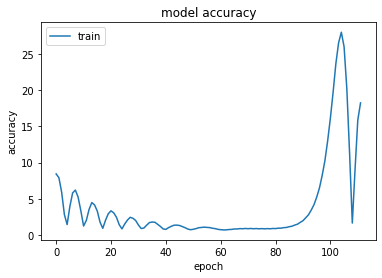

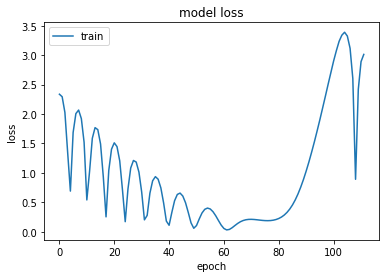

In [ ]:
print(history.history.keys())
plt.plot(history.history['mean_absolute_error'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
le = [math.log(x,10) for x in history.history['loss']]
# le = history.history['loss']
plt.plot(le)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
yRes = model.predict(xtest)
# lxa = yRes
lxa = [int(x[0]*100)/100 for x in yRes]
lxa = np.array(lxa)
lxb = [x for x in ytest]
lxb = np.array(lxb)
print(list(lxa-lxb))
print(list(lxa))
print(lxb)

[38.69, 62.55000000000018, 7.060000000000002, 8.599999999999994, 8.120000000000005, 4.34, 8.719999999999999, 4.019999999999996, 9.409999999999997, 7.099999999999994, 3.6899999999999977, 41.77999999999997, 5.060000000000002, 2.260000000000005, -21.769999999999982, -213.15000000000146, 4.8799999999999955, 1.5100000000000051, 44.39999999999998, 37.52000000000001, 3.280000000000001, 130.26000000000022, 1.480000000000004, 20.689999999999998, 9.389999999999986, 4.139999999999986, -61.460000000000036, 67.74000000000001, 10.629999999999995, 6.610000000000014, 5.150000000000006, 3.710000000000008, 3.6400000000000006, 5.829999999999998, 70.96000000000004, 5.350000000000023, 3.7900000000000063, 1.4500000000000028, 8.409999999999997, 4.530000000000001, 1.4000000000000057, 3.930000000000007, 2.8100000000000023, 0.6500000000000057, 1.620000000000001, 34.06, 3.769999999999996, 1.0900000000000034, 4.8799999999999955, 0.6200000000000045]
[202.69, 2108.55, 160.06, 210.6, 145.12, 10.34, 166.72, 88.02, 25

In [ ]:
model.save('DcaModel')

In [ ]:
# df = pd.read_csv('DcaTrainData0.csv')
# x = pd.get_dummies(df.drop(['isCondemn'],axis=1))
# y = df['isCondemn']
# yRes = model.predict(x)
# lres = [int(v[0]*1000)/1000 for v in yRes]
# lres = np.asarray(lres)
# y = np.asarray(y)
# # sim = lres.dot(y)/ (np.linalg.norm(lres) * np.linalg.norm(y))
# # print(int(sim*1000)/1000)
# print(lres - y)


# y = ytest
# yRes = model.predict(xtest)
# lres = [int(v[0]*1000)/1000 for v in yRes]
# lres = np.asarray(lres)
# y = np.asarray(y)
# sim = lres.dot(y)/ (np.linalg.norm(lres) * np.linalg.norm(y))
# print(sim)